In [3]:
import sklearn
import glob
import pickle
import os
import cv2
import numpy as np
import skimage
from skimage import data, color, exposure
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
from scipy.ndimage.measurements import label
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, Convolution3D, Flatten, Input, Conv2D, MaxPooling2D, Lambda, Activation, Reshape
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.transform import resize

%matplotlib inline
print("Modules imported")

Modules imported


## Creating and splitting the training data

In [4]:
X  = []

cars = glob.glob("./data/vehicles/*/*.png")
non_cars = glob.glob("./data/non-vehicles/*/*.png")

for car in cars:
    X.append(skimage.io.imread(car))

for non_car in non_cars:
    X.append(skimage.io.imread(non_car))

X = np.array(X)
# assign according image labels
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 4)

print('X_train:', X_train.shape)
print('X_test', X_test.shape)
print('y_train:', y_train.shape)
print('y_test', y_test.shape)

X_train: (6592, 64, 64, 3)
X_test (733, 64, 64, 3)
y_train: (6592,)
y_test (733,)


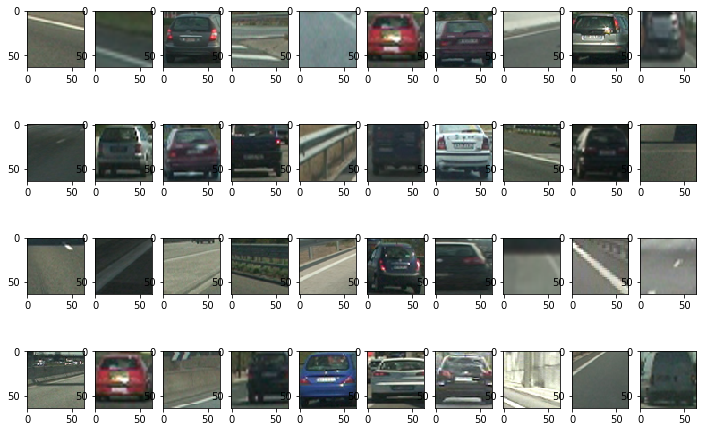

In [5]:
def showRandomImages():
    fig = plt.figure(figsize=(12,8))
    for i in range(0, 40):
        number = np.random.randint(0, len(X_train))
        axis = fig.add_subplot(4, 10, i + 1)
        axis.imshow(X_train[number])
    plt.show()

showRandomImages()

Training car examples quantity 3504
Training non-car examples quantity 3088
Testing car examples quantity 396
Testing non-car examples quantity 337


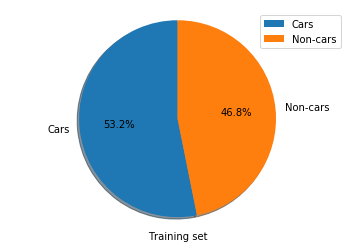

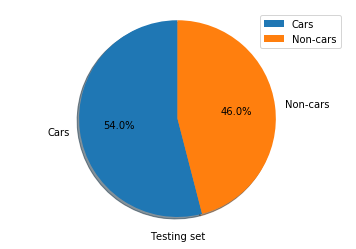

In [6]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
training_unique, training_counts = np.unique(y_train, return_counts = True)
test_unique, test_counts = np.unique(y_test, return_counts = True)
sizes = [training_counts, test_counts]

training_car_quantity = training_counts[0]
training_non_car_quantity = training_counts[1]

test_car_quantity = test_counts[0]
test_non_car_quantity = test_counts[1]

print('Training car examples quantity', training_car_quantity)
print('Training non-car examples quantity', training_non_car_quantity)
print('Testing car examples quantity', test_car_quantity)
print('Testing non-car examples quantity', test_non_car_quantity)

labels = ['Cars', 'Non-cars']
training_sizes = [training_car_quantity, training_non_car_quantity]
test_sizes = [test_car_quantity, test_non_car_quantity]


fig1, ax1 = plt.subplots()
ax1.pie(training_sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.xlabel('Training set')
plt.legend()
plt.show()

fig2, ax2 = plt.subplots()
ax2.pie(test_sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.xlabel('Testing set')
plt.legend()
plt.show()

## Building the CNN model

In [15]:
def create_model(input_shape=(64,64,3)):
    
    model = Sequential()
    
    # Center and normalize our data
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    
    # 1st conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Conv2D(60, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # 2nd conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Conv2D(86, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(Dropout(0.5))
    
    # 3rd conv layer with 128 filter, 3x3 each, 8x8 pooling and dropout
    model.add(Conv2D(128, 3, 3, activation='relu', name='conv3',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(4,4)))
    
    # This acts like a 128 neuron dense layer
    model.add(Conv2D(132,8,8,activation="relu",name="dense1")) 
    model.add(Dropout(0.5))
    
    # This is like a 1 neuron dense layer with tanh [-1, 1]
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) 
    
    return model

model = create_model()
model.summary()
model.add(Flatten())

INFO (theano.gof.compilelock): Refreshing lock /home/gusein/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.0-64/lock_dir/lock


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 60)        1680      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 60)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 86)        46526     
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 32, 86)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 128)       99200     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)         0         
__________

## Training the model

Train on 6592 samples, validate on 733 samples
Epoch 1/20
699s - loss: 0.0330 - acc: 0.9587 - val_loss: 0.0494 - val_acc: 0.9400
Epoch 2/20
697s - loss: 0.0240 - acc: 0.9694 - val_loss: 0.0564 - val_acc: 0.9291
Epoch 3/20
698s - loss: 0.0197 - acc: 0.9751 - val_loss: 0.0275 - val_acc: 0.9618
Epoch 4/20
683s - loss: 0.0155 - acc: 0.9800 - val_loss: 0.0276 - val_acc: 0.9618
Epoch 5/20
666s - loss: 0.0149 - acc: 0.9809 - val_loss: 0.0280 - val_acc: 0.9604
Epoch 6/20
666s - loss: 0.0114 - acc: 0.9854 - val_loss: 0.0511 - val_acc: 0.9332
Epoch 7/20
667s - loss: 0.0087 - acc: 0.9894 - val_loss: 0.0250 - val_acc: 0.9673
Epoch 8/20
666s - loss: 0.0081 - acc: 0.9900 - val_loss: 0.0219 - val_acc: 0.9714
Epoch 9/20
671s - loss: 0.0072 - acc: 0.9915 - val_loss: 0.0419 - val_acc: 0.9454
Epoch 10/20
695s - loss: 0.0060 - acc: 0.9933 - val_loss: 0.0587 - val_acc: 0.9209
Epoch 11/20
678s - loss: 0.0046 - acc: 0.9951 - val_loss: 0.0165 - val_acc: 0.9795
Epoch 12/20
665s - loss: 0.0062 - acc: 0.9930 - v

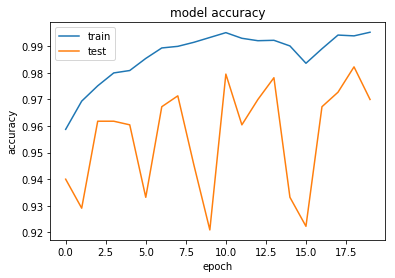

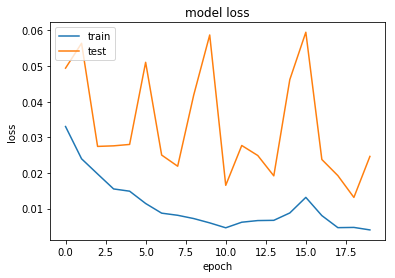

In [17]:
# Plot the results of the training
def plot_results(history):
    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size = 40, nb_epoch=20, verbose=2, validation_data=(X_test, y_test))

plot_results(history)

model.save_weights('model.h5')

In [18]:
# load the trained weights
model.load_weights('model.h5')
print("Weights loaded.")

Weights loaded.


### Select a random image from test set

(64, 64, 3)
NN Prediction: CAR with value 0.999979
Ground-truth: CAR with value 1.0


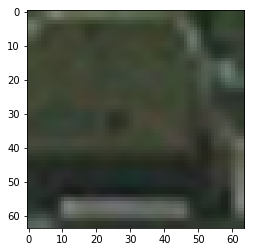

In [52]:
# pick a andom image
rand = np.random.randint(X_test.shape[0])
test_image = X_test[rand]
print(test_image.shape)
plt.imshow(test_image)

# predict the correct label
sample = np.reshape(X_test[rand], (1, 64,64,3))
prediction = model.predict(sample, batch_size=64, verbose=0)
prediction = prediction[0][0]

if prediction >= 0.5:
    print("NN Prediction: CAR with value " + str(prediction))
else:
    print("NN Prediction: NO CAR with value " + str(prediction))
    
# compare with the ground-truth
truth = y_test[rand]
if truth == 1:
    print("Ground-truth: CAR with value " + str(truth))
else:
    print("Ground-truth: NO CAR with value " + str(truth))

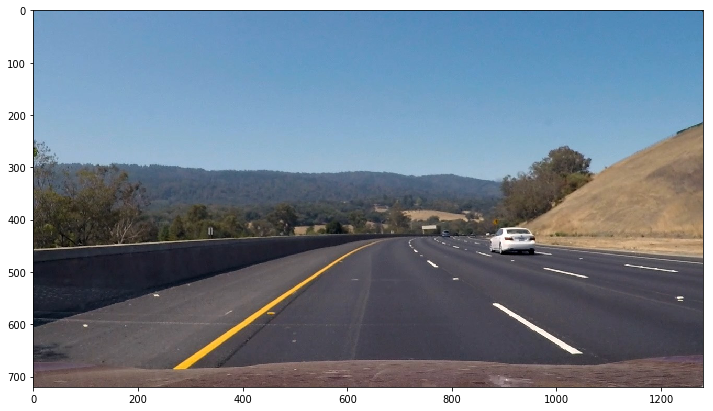

In [26]:
# load a non test set image to check the network on
img = skimage.io.imread('./data/sample.jpg')
print(img.shape)

fig = plt.figure(figsize=(12,20))
plt.imshow(img)

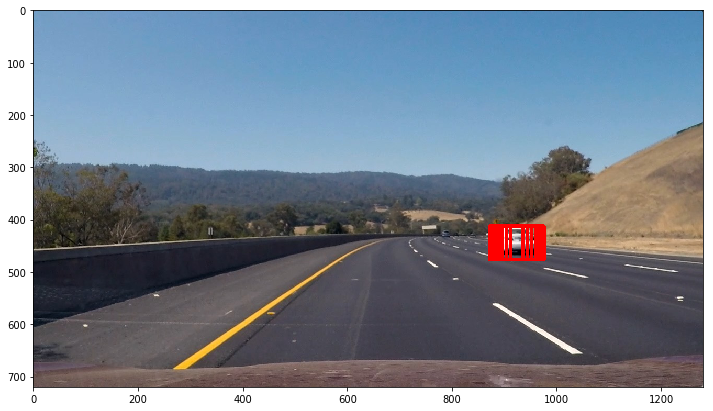

In [63]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)

    for bbox in bboxes:
        # draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)

    return draw_img

def search_cars(img):
    # crop the image to 300-660px in the vertical direction for road view purposes
    cropped = img[300:660, 0:1280]

    heat = heatmodel.predict(cropped.reshape(1,cropped.shape[0],cropped.shape[1],cropped.shape[2]))
    # find us rectangles that are interesting
    xx, yy = np.meshgrid(np.arange(heat.shape[2]),np.arange(heat.shape[1]))
    x = (xx[heat[0,:,:,0]>=1])
    y = (yy[heat[0,:,:,0]>=1])
    hot_windows = []
    # save those rects in a list
    for i,j in zip(x,y):
        hot_windows.append(((i*8, 300 + j*8), (i*8+64, 300 + j*8 + 64)))
    return hot_windows

# no flatten layer here
heatmodel = create_model((360, 1280, 3))
heatmodel.load_weights('model.h5')

# search for windows
hot_windows = search_cars(img)

# draw the found boxes on the test image
windowed_img = draw_boxes(img, hot_windows, (255, 0, 0), 6)                    

# show the image with the windows on top
fig = plt.figure(figsize=(12,20))
plt.imshow(windowed_img)
plt.show()

# Thresholding the heatmaps and finding a median